In [1]:
from utils import *

In [2]:
plot = False
## Delay Line Parameters:
delta_L1 = (72 - 3) * 0.0254
delta_L2 = (72 - 48) * 0.0254
delta_L3 = (48 - 3) * 0.0254
expected_ratios = [
    delta_L1 / delta_L3,  # Ratio 1 (L1 to L3)
    delta_L3 / delta_L2,   # Ratio 2 (L3 to L2)
    delta_L1 / delta_L2,   # Ratio 2 (L3 to L2)
]

In [3]:
def calculate_detection_rate_with_detectable_snr(data_dict, tolerance, threshold, bin_feature_name, bins, return_snr = False, los_nlos_mode = None):
    detection_dict = {}
    for bin_range in bins:
        detection_dict[bin_range] = {"detected": 0, "total": 0, "snr": 0}
    # select NLOS or LOS data
    if los_nlos_mode is not None:
        if los_nlos_mode == "los":
            filenames = [filename for filename in filenames if "-d" not in filename]
        if los_nlos_mode == "nlos":
            filenames = [filename for filename in filenames if "-d" in filename]
    
    # Find the best triplet for each data object
    for data_key in data_dict:
        data_obj = data_dict[data_key]
        try:
            best_triplet, snr, _ = find_beat_freq_triplet_with_expected_ratio(expected_ratios, tolerance, data_obj, radar_detection_mode = True, small_peak_cal = 200, plot = plot, return_snr = True)
            if best_triplet:
                coverage = 1
            else:
                coverage = 0
                snr = 0
        except Exception as e:
            print(f"Error for {data_key}: {e}")
            coverage = 0
            snr = 0
        data_obj['score'] = coverage
        data_obj['snr'] = snr
            
    for data_obj in data_dict.values():
        bin_feature = data_obj[bin_feature_name]
        score = data_obj['score']

        bin_range = bins[np.argmax(bin_feature < bins) - 1]
        detection_dict[bin_range]["total"] += 1
        if score >= threshold:
            detection_dict[bin_range]["snr"] += data_obj["snr"] # * Only taking detectable SNR
            detection_dict[bin_range]["detected"] += 1
        
    bin_values = []
    snr_values = []
    for detection_data in detection_dict.values():
        if detection_data["total"] == 0:
            bin_values.append(0)
            snr_values.append(0)
            print("Error! No data in bin")
            continue
        bin_values.append(detection_data["detected"] / detection_data["total"])
        snr_values.append(detection_data["snr"] / detection_data["detected"] if detection_data["detected"] > 0 else 0)

    if return_snr:
        return bin_values, snr_values
    return bin_values

In [4]:
threshold = 0.5
tolerance = 1

range_bins = np.array([0, 5, 10, 15, 20, 25])

los_directory_path = "./Data/fig10-los"
los_data_dict = read_data_dict(los_directory_path)
los_dist_data, los_dist_snr = calculate_detection_rate_with_detectable_snr(los_data_dict, tolerance, threshold, "distance", range_bins, return_snr=True)

In [5]:
nlos_directory_path = "./Data/fig10-nlos"
nlos_data_dict = read_data_dict(nlos_directory_path)
nlos_dist_data, nlos_dist_snr = calculate_detection_rate_with_detectable_snr(nlos_data_dict, tolerance, threshold, "distance", range_bins, return_snr=True)

Error for 28-0-2-9000-10000-0.00019999999999999998-100: Score too low, signal not periodic!
Error for 28-0-4-9000-10000-0.00019999999999999998-100: Score too low, signal not periodic!


['No Radar', '[0, 5)', '[5, 10)', '[10, 15)', '[15, 20)', '[20, 25)', '[25, 30)'] [1.         1.         1.         1.         1.         0.96363636
 0.66666667] [1.         1.         1.         1.         0.86666667 0.66666667
 0.27272727]


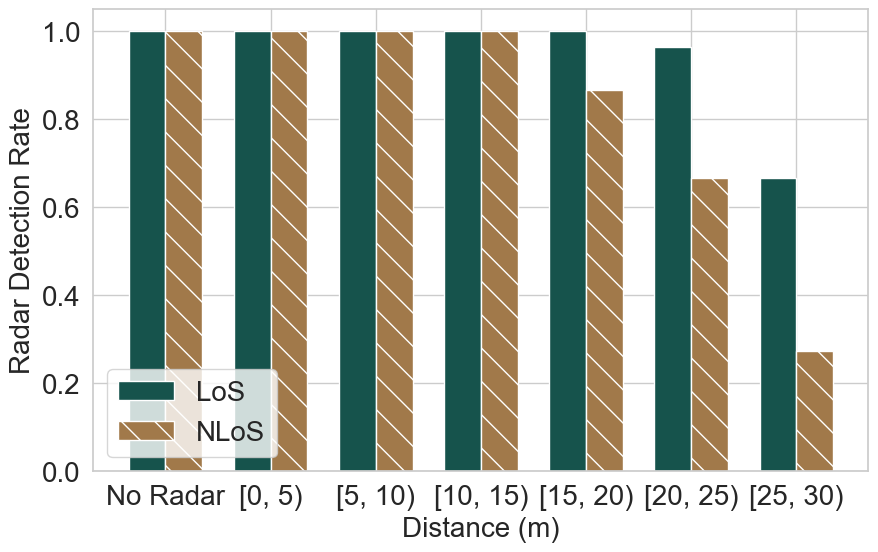

In [6]:
import seaborn as sns
color_map = sns.color_palette("cubehelix", 3).as_hex() # !!!! <- COLOR PALLETTE

# Set seaborn style
sns.set(style="whitegrid")

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 25
matplotlib.rcParams['lines.linewidth'] = 5

fontsize = 20
matplotlib.rcParams['xtick.labelsize'] = fontsize
matplotlib.rcParams['ytick.labelsize'] = fontsize
matplotlib.rcParams['legend.fontsize'] = fontsize
matplotlib.rcParams['axes.labelsize'] = fontsize

plt.figure(figsize = (10, 6))

range_bin_names = [f"[{r}, {r+5})" for r in range_bins]
range_bin_names.insert(0, "No Radar")
# range_bin_names = np.concatenate((np.array(["No Radar"]), range_bin_names))
los_dist_data_extended = np.concatenate(([1], los_dist_data))
nlos_dist_data_extended = np.concatenate(([1], nlos_dist_data))
print(range_bin_names, los_dist_data_extended, nlos_dist_data_extended)

bar_width = 0.35
xloc = np.arange(len(range_bin_names))
plt.bar(xloc, los_dist_data_extended, color=color_map[0], hatch='', label='LoS', width = bar_width)
plt.bar(xloc + bar_width, nlos_dist_data_extended, color=color_map[1], hatch='\\', label='NLoS', width = bar_width)
plt.xticks(xloc + bar_width / 2, range_bin_names)
plt.xlabel("Distance (m)")
plt.ylabel("Radar Detection Rate")
plt.legend(loc = "lower left")

['[0, 5)', '[5, 10)', '[10, 15)', '[15, 20)', '[20, 25)', '[25, 30)'] [37.79138041 25.06943812 23.74424202 18.83762114 14.20641262 17.88778787] [31.04119321 19.92229968 11.29137011 12.26947669  7.26814572  3.74598927]


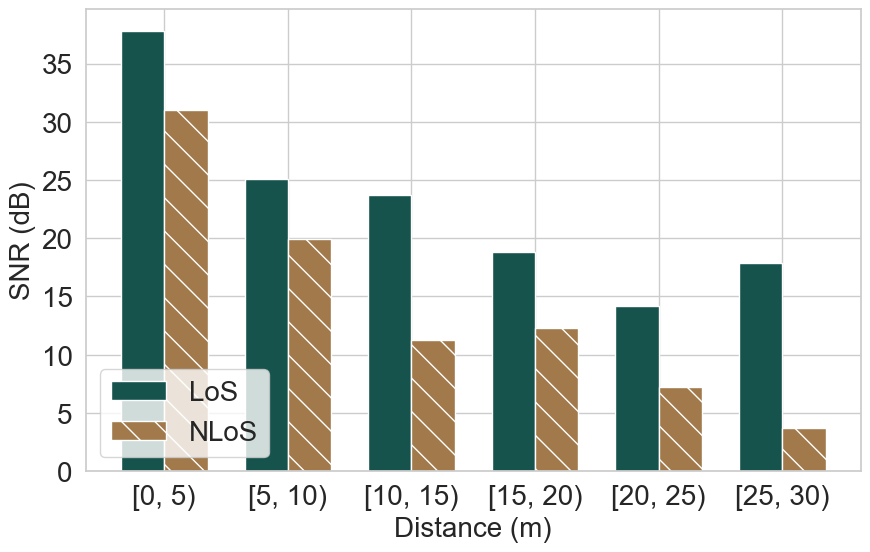

In [7]:
# Set seaborn style
sns.set(style="whitegrid")

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 25
matplotlib.rcParams['lines.linewidth'] = 5

fontsize = 20
matplotlib.rcParams['xtick.labelsize'] = fontsize
matplotlib.rcParams['ytick.labelsize'] = fontsize
matplotlib.rcParams['legend.fontsize'] = fontsize
matplotlib.rcParams['axes.labelsize'] = fontsize

plt.figure(figsize = (10, 6))

range_bin_names = [f"[{r}, {r+5})" for r in range_bins]
los_dist_snr_extended = 10 * np.log10(los_dist_snr)
nlos_dist_snr_extended = 10 * np.log10(nlos_dist_snr)
print(range_bin_names, los_dist_snr_extended, nlos_dist_snr_extended)

bar_width = 0.35
xloc = np.arange(len(range_bin_names))
plt.bar(xloc, los_dist_snr_extended, color=color_map[0], hatch='', label='LoS', width = bar_width)
plt.bar(xloc + bar_width, nlos_dist_snr_extended, color=color_map[1], hatch='\\', label='NLoS', width = bar_width)
plt.xticks(xloc + bar_width / 2, range_bin_names)
plt.xlabel("Distance (m)")
plt.ylabel("SNR (dB)")
plt.legend(loc = "lower left")